# LoRA vs Full Fine-Tuning: A Comparative Study

## Learning Objectives

By completing this notebook, you will:

1. ✅ Understand the difference between **Full Fine-Tuning** and **Parameter-Efficient Fine-Tuning (LoRA)**
2. ✅ Learn to work with GPUs for deep learning training
3. ✅ Compare training efficiency, memory usage, and model performance
4. ✅ Gain hands-on experience with HuggingFace Transformers and Adapters

## What is LoRA?

**LoRA (Low-Rank Adaptation)** is a parameter-efficient fine-tuning technique that:
- Freezes the pretrained model weights
- Injects trainable low-rank decomposition matrices into attention layers
- Achieves comparable performance with **<1% of trainable parameters**

## Experimental Setup

We'll run two types of experiments:

### 🏃 Quick Experiment (CPU-friendly, ~5-10 minutes)
- **Dataset**: Rotten Tomatoes (~8.5K reviews)
- **Model**: RoBERTa-base (~125M parameters)
- **Good for**: Understanding concepts, quick iterations

### 🚀 Full Experiment (Requires GPU, ~30-60 minutes)
- **Dataset**: IMDB (~50K reviews)  
- **Model**: RoBERTa-large (~355M parameters)
- **Good for**: Seeing real-world benefits of LoRA, GPU utilization

---

In [9]:
# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================
# 👉 STUDENTS: Change this to switch between quick and full experiments

EXPERIMENT_MODE = "quick"  # Options: "quick" or "full"

# Quick mode: Fast, works on CPU, good for learning
# Full mode: Requires GPU, shows real-world performance

# ============================================================================
# Experiment parameters (auto-configured based on mode)
# ============================================================================

if EXPERIMENT_MODE == "quick":
    CONFIG = {
        'dataset_name': 'rotten_tomatoes',
        'model_name': 'roberta-base',
        'max_length': 128,
        'num_labels': 2,
        'num_epochs': 3,
        'batch_size': 16,
        'learning_rate_full': 2e-5,
        'learning_rate_lora': 1e-4,
        'lora_rank': 8,
        'description': 'Quick experiment with Rotten Tomatoes + RoBERTa-base'
    }
elif EXPERIMENT_MODE == "full":
    CONFIG = {
        'dataset_name': 'imdb',
        'model_name': 'roberta-large',
        'max_length': 512,
        'num_labels': 2,
        'num_epochs': 3,
        'batch_size': 8,
        'learning_rate_full': 2e-5,
        'learning_rate_lora': 3e-4,
        'lora_rank': 16,
        'description': 'Full experiment with IMDB + RoBERTa-large (GPU required)'
    }
else:
    raise ValueError("EXPERIMENT_MODE must be 'quick' or 'full'")

print("="*80)
print(f"🔧 Configuration: {CONFIG['description']}")
print("="*80)
for key, value in CONFIG.items():
    print(f"  {key:25s}: {value}")
print("="*80)

🔧 Configuration: Quick experiment with Rotten Tomatoes + RoBERTa-base
  dataset_name             : rotten_tomatoes
  model_name               : roberta-base
  max_length               : 128
  num_labels               : 2
  num_epochs               : 3
  batch_size               : 16
  learning_rate_full       : 2e-05
  learning_rate_lora       : 0.0001
  lora_rank                : 8
  description              : Quick experiment with Rotten Tomatoes + RoBERTa-base


In [10]:
# ============================================================================
# IMPORTS
# ============================================================================

# Standard libraries
import os
import json
import time
import tempfile
import shutil
from datetime import datetime

# Data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn

# HuggingFace Transformers
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoConfig,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    EvalPrediction,
    IntervalStrategy
)

# Adapters library
from adapters import AutoAdapterModel, LoRAConfig, AdapterTrainer

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All imports successful!")

✅ All imports successful!


In [11]:
# ============================================================================
# GPU AVAILABILITY CHECK
# ============================================================================

def check_gpu():
    """Check GPU availability and print details"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        print("🎮 GPU Status: AVAILABLE ✅")
        print(f"   Device: {gpu_name}")
        print(f"   Memory: {gpu_memory:.2f} GB")
        print(f"   CUDA Version: {torch.version.cuda}")
        
        if EXPERIMENT_MODE == "full":
            print("\n✅ Perfect! GPU is available for full experiment.")
        else:
            print("\n✅ GPU available but running quick mode. Consider switching to 'full' mode!")
    else:
        device = torch.device("cpu")
        print("💻 GPU Status: NOT AVAILABLE ❌")
        print("   Running on CPU")
        
        if EXPERIMENT_MODE == "full":
            print("\n⚠️  WARNING: Full mode requires GPU. Consider:")
            print("   1. Switch to 'quick' mode, or")
            print("   2. Enable GPU in your environment")
        else:
            print("\n✅ CPU is sufficient for quick mode.")
    
    return device

device = check_gpu()
print(f"\n📍 Using device: {device}")

🎮 GPU Status: AVAILABLE ✅
   Device: Quadro RTX 6000
   Memory: 21.97 GB
   CUDA Version: 12.8

✅ GPU available but running quick mode. Consider switching to 'full' mode!

📍 Using device: cuda


In [12]:
# ============================================================================
# DATASET PREPARATION
# ============================================================================

def load_and_prepare_dataset(dataset_name):
    """Load dataset and print statistics"""
    print(f"\n📚 Loading dataset: {dataset_name}")
    print("-" * 80)
    
    if dataset_name == "rotten_tomatoes":
        dataset = load_dataset("rotten_tomatoes")
        text_field = "text"
    elif dataset_name == "imdb":
        dataset = load_dataset("imdb")
        text_field = "text"
    elif dataset_name == "sst2":
        dataset = load_dataset("glue", "sst2")
        text_field = "sentence"
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    
    # Print dataset statistics
    print(f"✅ Dataset loaded successfully!")
    print(f"\nDataset splits:")
    for split in dataset.keys():
        print(f"  {split:12s}: {len(dataset[split]):,} examples")
    
    # Show sample
    print(f"\n📝 Sample from training set:")
    sample = dataset['train'][0]
    print(f"  Text: {sample[text_field][:100]}...")
    print(f"  Label: {sample['label']} ({'Positive' if sample['label'] == 1 else 'Negative'})")
    
    return dataset, text_field

# Load dataset
dataset, text_field = load_and_prepare_dataset(CONFIG['dataset_name'])


📚 Loading dataset: rotten_tomatoes
--------------------------------------------------------------------------------
✅ Dataset loaded successfully!

Dataset splits:
  train       : 8,530 examples
  validation  : 1,066 examples
  test        : 1,066 examples

📝 Sample from training set:
  Text: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash eve...
  Label: 1 (Positive)


In [13]:
# ============================================================================
# TOKENIZATION
# ============================================================================

def tokenize_dataset(dataset, text_field, model_name, max_length):
    """Tokenize the dataset"""
    print(f"\n🔤 Tokenizing dataset with {model_name}")
    print("-" * 80)
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    def tokenize_function(examples):
        return tokenizer(
            examples[text_field],
            max_length=max_length,
            truncation=True,
            padding='max_length'
        )
    
    # Tokenize all splits
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        desc="Tokenizing"
    )
    
    # Remove text column, keep only model inputs
    columns_to_remove = [col for col in tokenized_dataset['train'].column_names 
                        if col not in ['input_ids', 'attention_mask', 'label']]
    tokenized_dataset = tokenized_dataset.remove_columns(columns_to_remove)
    
    # Set format for PyTorch
    tokenized_dataset.set_format('torch')
    
    print(f"✅ Tokenization complete!")
    print(f"   Max length: {max_length}")
    print(f"   Vocabulary size: {len(tokenizer)}")
    
    return tokenized_dataset, tokenizer

# Tokenize dataset
tokenized_dataset, tokenizer = tokenize_dataset(
    dataset, 
    text_field, 
    CONFIG['model_name'],
    CONFIG['max_length']
)


🔤 Tokenizing dataset with roberta-base
--------------------------------------------------------------------------------


Tokenizing: 100%|██████████| 1066/1066 [00:00<00:00, 9970.74 examples/s] 

✅ Tokenization complete!
   Max length: 128
   Vocabulary size: 50265


# Understanding Full Fine-Tuning vs LoRA: Model Architecture Differences

## Two Training Approaches

### 1️⃣ Full Fine-Tuning (Traditional Approach)

**What happens:**
* All 125M-355M parameters are trainable
* Entire model adapts to your specific task
* Requires more GPU memory (stores gradients for all parameters)
* Slower training (more parameters to update)

**Architecture:** Input → [RoBERTa Encoder - ALL TRAINABLE ✅] → Classifier → Output (125M-355M parameters being updated)


---

### 2️⃣ LoRA (Parameter-Efficient Approach)

**What happens:**
* Base model frozen (125M-355M parameters)
* Only small adapter matrices are trainable (~300K-1M parameters)
* Low-rank decomposition: Instead of updating W directly, we add ΔW = A×B where A and B are small matrices
* 100-1000x fewer trainable parameters!

**Architecture:** Input → [RoBERTa Encoder - FROZEN ❄️ + LoRA Adapters - TRAINABLE ✅] → Classifier → Output (Only 0.1-1% parameters being updated)


**Key Insight:** LoRA achieves 95-99% of full fine-tuning performance with <1% of parameters!

---

In [14]:
# ============================================================================
# MODEL CREATION FUNCTIONS
# ============================================================================

def create_full_finetuning_model(model_name, num_labels):
    """Create a model for full fine-tuning"""
    print(f"\n🏗️  Creating Full Fine-Tuning Model")
    print("-" * 80)
    
    model = RobertaForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"✅ Model created: RobertaForSequenceClassification")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,} (100%)")
    
    return model


def create_lora_model(model_name, num_labels, rank=8, alpha=16):
    """Create a model with LoRA adapters"""
    print(f"\n🏗️  Creating LoRA Model")
    print("-" * 80)
    
    # Load model with adapter support
    config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
    model = AutoAdapterModel.from_pretrained(model_name, config=config)
    
    # Configure LoRA
    lora_config = LoRAConfig(
        r=rank,                          # Rank of decomposition
        alpha=alpha,                     # Scaling factor
        dropout=0.1,
        selfattn_lora=False,            # Don't apply to self-attention projection
        intermediate_lora=True,          # Apply to intermediate layers
        output_lora=False,               # Don't apply to output
        attn_matrices=["q", "v"],        # Apply to Query and Value matrices
        composition_mode="add",
        init_weights="lora"
    )
    
    # Add adapter
    model.add_adapter("lora_adapter", config=lora_config)
    
    # Add classification head
    model.add_classification_head(
        "lora_adapter",
        num_labels=num_labels,
        id2label={0: "negative", 1: "positive"}
    )
    
    # 🔥 THIS IS WHERE THE FREEZING HAPPENS! 🔥
    # train_adapter() freezes all base model parameters and only enables
    # gradients for the adapter parameters
    print("\n🔒 Activating adapter (freezing base model, unfreezing adapter)...")
    model.train_adapter("lora_adapter")

    # === VERIFICATION: Let's explicitly show what's frozen ===
    print("\n📊 Parameter Status After train_adapter():")
    print("-" * 80)
    
    # Collect all parameters first
    frozen_list = []
    trainable_list = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_list.append((name, param.numel()))
        else:
            frozen_list.append((name, param.numel()))
    
    # Show examples of frozen parameters
    print(f"\n❄️  FROZEN Parameters (showing first 5 of {len(frozen_list)} total):")
    for name, size in frozen_list[:5]:
        print(f"   {name}")
        print(f"      └─ Size: {size:,} params")
    if len(frozen_list) > 5:
        print(f"   ... and {len(frozen_list) - 5} more frozen parameters")
    
    # Show examples of trainable parameters
    print(f"\n✅ TRAINABLE Parameters (showing first 10 of {len(trainable_list)} total):")
    for name, size in trainable_list[:10]:
        print(f"   {name}")
        print(f"      └─ Size: {size:,} params")
    if len(trainable_list) > 10:
        print(f"   ... and {len(trainable_list) - 10} more trainable parameters")
    
    # Calculate totals
    frozen_params = sum(size for _, size in frozen_list)
    trainable_params = sum(size for _, size in trainable_list)
    total_params = frozen_params + trainable_params
    trainable_percentage = 100 * trainable_params / total_params
    
    print("\n" + "=" * 80)
    print("📈 SUMMARY")
    print("=" * 80)
    print(f"✅ Model created: RobertaAdapterModel with LoRA")
    print(f"\nParameter Breakdown:")
    print(f"   Total parameters:      {total_params:>15,}")
    print(f"   Frozen parameters:     {frozen_params:>15,} ❄️  ({100 * frozen_params / total_params:.2f}%)")
    print(f"   Trainable parameters:  {trainable_params:>15,} 🔥 ({trainable_percentage:.2f}%)")
    print(f"\nLoRA Configuration:")
    print(f"   Rank (r):              {rank:>15}")
    print(f"   Alpha:                 {alpha:>15}")
    print(f"   Target matrices:       {'q, v':>15}")
    print(f"\nEfficiency Gain:")
    print(f"   Parameter reduction:   {total_params/trainable_params:>15.1f}x fewer trainable params")
    print(f"   Memory savings:        ~{100 - trainable_percentage:>14.2f}% less gradient memory")
    print("=" * 80)
    
    return model


def compute_metrics(eval_pred: EvalPrediction):
    """Compute accuracy metric"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

print("✅ Model creation functions defined")

✅ Model creation functions defined


In [15]:
# ============================================================================
# EXPERIMENT RUNNER
# ============================================================================

def run_experiment(
    model,
    tokenized_dataset,
    experiment_name,
    learning_rate,
    num_epochs,
    batch_size,
    is_full_finetuning=True
):
    """Run a training experiment and return results"""
    
    print(f"\n{'='*80}")
    print(f"🚀 Starting Experiment: {experiment_name}")
    print(f"{'='*80}\n")
    
    # Move model to device
    model.to(device)
    
    # Create temporary output directory
    output_dir = tempfile.mkdtemp()
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy=IntervalStrategy.EPOCH,
        save_strategy=IntervalStrategy.NO,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f"{output_dir}/logs",
        logging_steps=50,
        load_best_model_at_end=False,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
        report_to="none",  # Disable wandb/tensorboard
        remove_unused_columns=False,
    )
    
    # Choose trainer type
    TrainerClass = Trainer if is_full_finetuning else AdapterTrainer
    
    trainer = TrainerClass(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"] if "test" in tokenized_dataset else tokenized_dataset["validation"],
        compute_metrics=compute_metrics,
    )
    
    # Train
    print("🏋️  Training started...")
    start_time = time.time()
    
    train_result = trainer.train()
    
    training_time = time.time() - start_time
    
    print(f"\n✅ Training complete! Time: {training_time:.2f}s ({training_time/60:.2f} min)")
    
    # Evaluate
    print("\n📊 Evaluating model...")
    eval_result = trainer.evaluate()
    
    # Collect results
    results = {
        'experiment_name': experiment_name,
        'training_time': training_time,
        'train_loss': train_result.training_loss,
        'eval_loss': eval_result['eval_loss'],
        'eval_accuracy': eval_result['eval_accuracy'],
        'total_params': sum(p.numel() for p in model.parameters()),
        'trainable_params': sum(p.numel() for p in model.parameters() if p.requires_grad),
    }
    
    results['trainable_percentage'] = 100 * results['trainable_params'] / results['total_params']
    
    # Print summary
    print(f"\n📈 Results Summary:")
    print(f"   Training Loss: {results['train_loss']:.4f}")
    print(f"   Eval Loss: {results['eval_loss']:.4f}")
    print(f"   Eval Accuracy: {results['eval_accuracy']:.4f}")
    print(f"   Training Time: {results['training_time']:.2f}s")
    
    # Cleanup
    shutil.rmtree(output_dir, ignore_errors=True)
    
    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return results, model

print("✅ Experiment runner defined")

✅ Experiment runner defined


In [16]:
# ============================================================================
# EXPERIMENT 1: FULL FINE-TUNING (BASELINE)
# ============================================================================

print("\n" + "="*80)
print("EXPERIMENT 1: FULL FINE-TUNING")
print("="*80)
print("This is our baseline. All model parameters will be updated.")
print("Expected: Best accuracy, but slower and more memory-intensive.")
print("="*80)

# Create model
model_full = create_full_finetuning_model(
    CONFIG['model_name'],
    CONFIG['num_labels']
)

# Run experiment
results_full, trained_model_full = run_experiment(
    model=model_full,
    tokenized_dataset=tokenized_dataset,
    experiment_name="Full Fine-Tuning",
    learning_rate=CONFIG['learning_rate_full'],
    num_epochs=CONFIG['num_epochs'],
    batch_size=CONFIG['batch_size'],
    is_full_finetuning=True
)

print("\n✅ Full fine-tuning experiment completed!")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



EXPERIMENT 1: FULL FINE-TUNING
This is our baseline. All model parameters will be updated.
Expected: Best accuracy, but slower and more memory-intensive.

🏗️  Creating Full Fine-Tuning Model
--------------------------------------------------------------------------------
✅ Model created: RobertaForSequenceClassification
   Total parameters: 124,647,170
   Trainable parameters: 124,647,170 (100%)

🚀 Starting Experiment: Full Fine-Tuning

🏋️  Training started...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.310300,0.347692,0.865854
2,0.234500,0.405061,0.883677
3,0.164800,0.508547,0.881801



✅ Training complete! Time: 116.15s (1.94 min)

📊 Evaluating model...



📈 Results Summary:
   Training Loss: 0.2894
   Eval Loss: 0.5085
   Eval Accuracy: 0.8818
   Training Time: 116.15s

✅ Full fine-tuning experiment completed!


In [17]:
# ============================================================================
# EXPERIMENT 2: LoRA (PARAMETER-EFFICIENT)
# ============================================================================

print("\n" + "="*80)
print("EXPERIMENT 2: LoRA FINE-TUNING")
print("="*80)
print("Only a small fraction of parameters will be updated.")
print("Expected: Comparable accuracy, much faster, less memory.")
print("="*80)

# Create model
model_lora = create_lora_model(
    CONFIG['model_name'],
    CONFIG['num_labels'],
    rank=CONFIG['lora_rank'],
    alpha=CONFIG['lora_rank'] * 2  # Common practice: alpha = 2 * rank
)

# Run experiment
results_lora, trained_model_lora = run_experiment(
    model=model_lora,
    tokenized_dataset=tokenized_dataset,
    experiment_name="LoRA Fine-Tuning",
    learning_rate=CONFIG['learning_rate_lora'],
    num_epochs=CONFIG['num_epochs'],
    batch_size=CONFIG['batch_size'],
    is_full_finetuning=False
)

print("\n✅ LoRA experiment completed!")


EXPERIMENT 2: LoRA FINE-TUNING
Only a small fraction of parameters will be updated.
Expected: Comparable accuracy, much faster, less memory.

🏗️  Creating LoRA Model
--------------------------------------------------------------------------------


Some weights of RobertaAdapterModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['heads.default.3.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
There are adapters available but none are activated for the forward pass.



🔒 Activating adapter (freezing base model, unfreezing adapter)...

📊 Parameter Status After train_adapter():
--------------------------------------------------------------------------------

❄️  FROZEN Parameters (showing first 5 of 199 total):
   roberta.embeddings.word_embeddings.weight
      └─ Size: 38,603,520 params
   roberta.embeddings.position_embeddings.weight
      └─ Size: 394,752 params
   roberta.embeddings.token_type_embeddings.weight
      └─ Size: 768 params
   roberta.embeddings.LayerNorm.weight
      └─ Size: 768 params
   roberta.embeddings.LayerNorm.bias
      └─ Size: 768 params
   ... and 194 more frozen parameters

✅ TRAINABLE Parameters (showing first 10 of 33 total):
   roberta.encoder.layer.0.intermediate.dense.loras.lora_adapter.lora_A
      └─ Size: 6,144 params
   roberta.encoder.layer.0.intermediate.dense.loras.lora_adapter.lora_B
      └─ Size: 24,576 params
   roberta.encoder.layer.1.intermediate.dense.loras.lora_adapter.lora_A
      └─ Size: 6,144 para

Epoch,Training Loss,Validation Loss,Accuracy
1,0.327100,0.319429,0.873358
2,0.318200,0.310345,0.882739
3,0.233100,0.315644,0.880863



✅ Training complete! Time: 82.16s (1.37 min)

📊 Evaluating model...



📈 Results Summary:
   Training Loss: 0.3342
   Eval Loss: 0.3156
   Eval Accuracy: 0.8809
   Training Time: 82.16s

✅ LoRA experiment completed!


In [18]:
# ============================================================================
# COMPARISON ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("📊 COMPARATIVE ANALYSIS")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame([results_full, results_lora])
comparison_df = comparison_df.set_index('experiment_name')

print("\n📋 Detailed Comparison:")
print(comparison_df.to_string())

# Calculate relative metrics
print("\n" + "="*80)
print("🎯 KEY INSIGHTS")
print("="*80)

speedup = results_full['training_time'] / results_lora['training_time']
param_reduction = results_full['trainable_params'] / results_lora['trainable_params']
accuracy_diff = results_lora['eval_accuracy'] - results_full['eval_accuracy']
accuracy_retention = (results_lora['eval_accuracy'] / results_full['eval_accuracy']) * 100

print(f"\n1️⃣ Parameter Efficiency:")
print(f"   Full Fine-Tuning: {results_full['trainable_params']:,} parameters ({results_full['trainable_percentage']:.1f}%)")
print(f"   LoRA: {results_lora['trainable_params']:,} parameters ({results_lora['trainable_percentage']:.2f}%)")
print(f"   📉 Reduction: {param_reduction:.1f}x fewer parameters!")

print(f"\n2️⃣ Training Speed:")
print(f"   Full Fine-Tuning: {results_full['training_time']:.2f}s")
print(f"   LoRA: {results_lora['training_time']:.2f}s")
print(f"   ⚡ Speedup: {speedup:.2f}x faster!")

print(f"\n3️⃣ Model Performance:")
print(f"   Full Fine-Tuning Accuracy: {results_full['eval_accuracy']:.4f}")
print(f"   LoRA Accuracy: {results_lora['eval_accuracy']:.4f}")
print(f"   📊 Difference: {accuracy_diff:+.4f} ({(accuracy_diff/results_full['eval_accuracy'])*100:+.2f}%)")
print(f"   ✅ Accuracy Retention: {accuracy_retention:.2f}%")

print(f"\n4️⃣ Overall Verdict:")
if accuracy_retention >= 95:
    print(f"   🏆 Excellent! LoRA achieves {accuracy_retention:.1f}% of full fine-tuning performance")
    print(f"      with {param_reduction:.1f}x fewer parameters and {speedup:.2f}x speedup!")
else:
    print(f"   ⚠️  LoRA accuracy is lower ({accuracy_retention:.1f}% retention).")
    print(f"      Consider increasing LoRA rank or adjusting hyperparameters.")

# Save results
results_dict = {
    'config': CONFIG,
    'full_finetuning': results_full,
    'lora': results_lora,
    'comparison': {
        'speedup': float(speedup),
        'param_reduction': float(param_reduction),
        'accuracy_retention': float(accuracy_retention)
    }
}

with open('experiment_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"\n💾 Results saved to: experiment_results.json")


📊 COMPARATIVE ANALYSIS

📋 Detailed Comparison:
                  training_time  train_loss  eval_loss  eval_accuracy  total_params  trainable_params  trainable_percentage
experiment_name                                                                                                            
Full Fine-Tuning     116.154015    0.289385   0.508547       0.881801     124647170         124647170            100.000000
LoRA Fine-Tuning      82.157469    0.334204   0.315644       0.880863     126248795           1603163              1.269844

🎯 KEY INSIGHTS

1️⃣ Parameter Efficiency:
   Full Fine-Tuning: 124,647,170 parameters (100.0%)
   LoRA: 1,603,163 parameters (1.27%)
   📉 Reduction: 77.8x fewer parameters!

2️⃣ Training Speed:
   Full Fine-Tuning: 116.15s
   LoRA: 82.16s
   ⚡ Speedup: 1.41x faster!

3️⃣ Model Performance:
   Full Fine-Tuning Accuracy: 0.8818
   LoRA Accuracy: 0.8809
   📊 Difference: -0.0009 (-0.11%)
   ✅ Accuracy Retention: 99.89%

4️⃣ Overall Verdict:
   🏆 Excellent

📊 Visualization saved as: lora_comparison.png


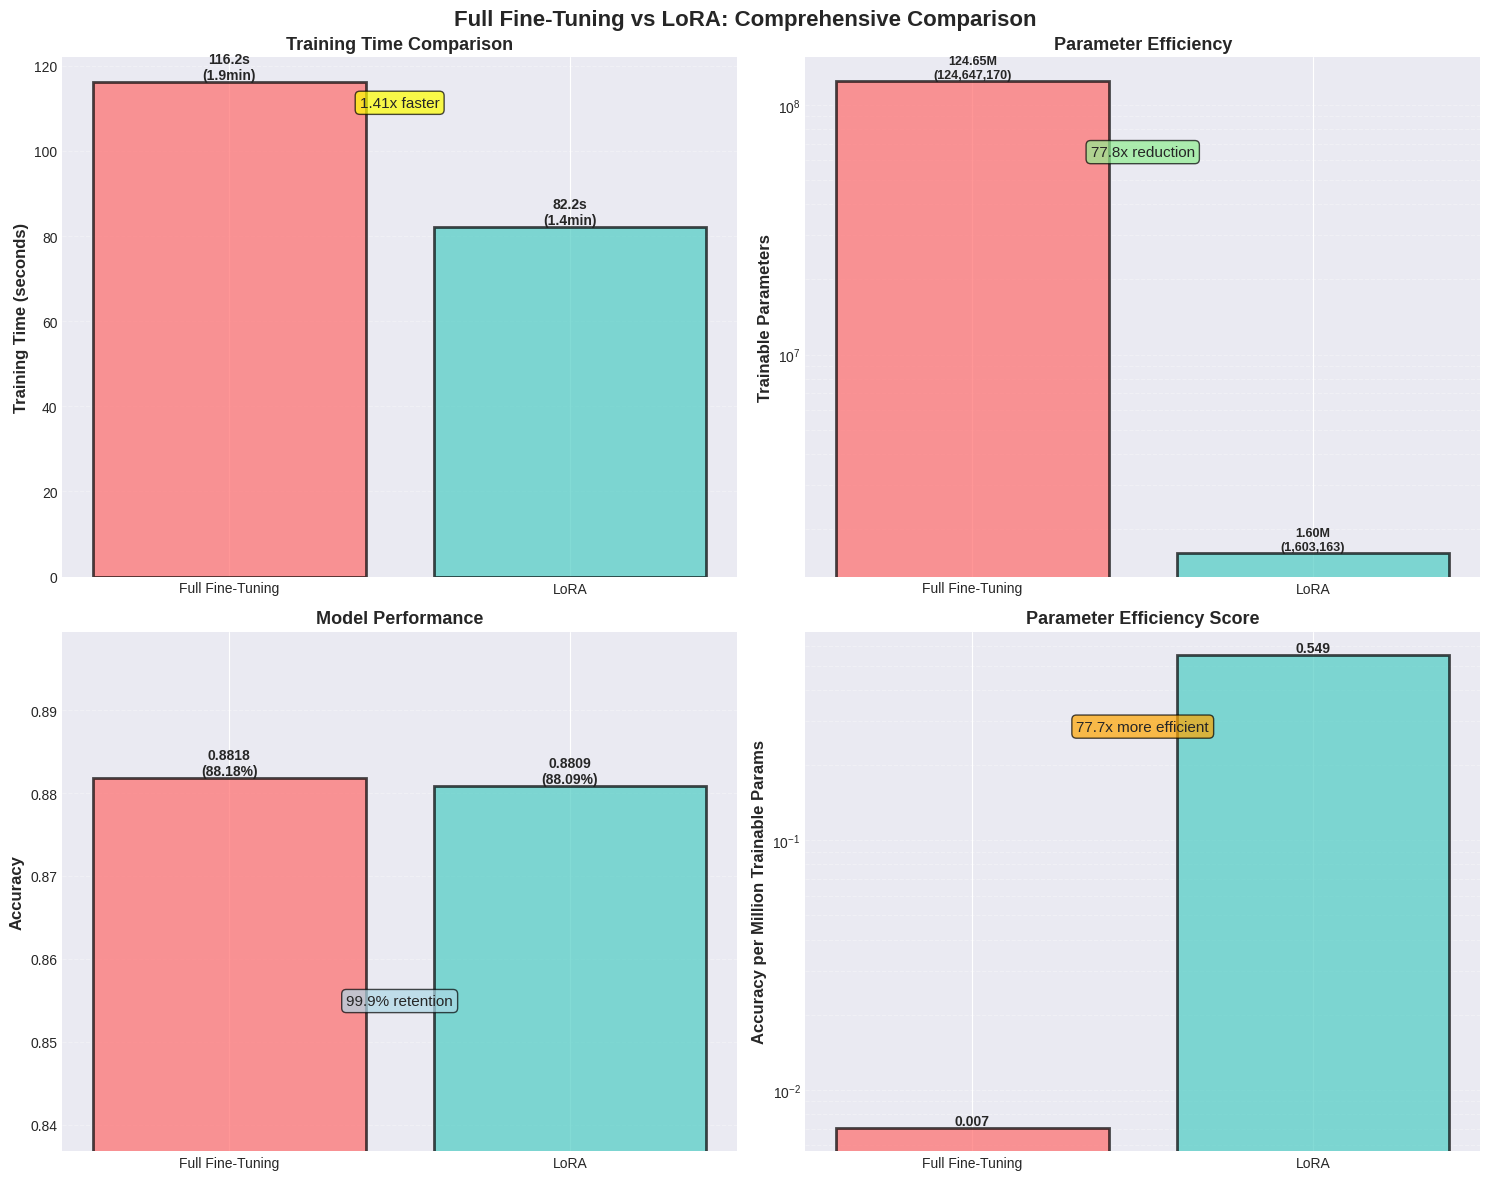

In [19]:
# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Full Fine-Tuning vs LoRA: Comprehensive Comparison', 
             fontsize=16, fontweight='bold')

# Color scheme
colors = ['#FF6B6B', '#4ECDC4']
methods = ['Full Fine-Tuning', 'LoRA']

# Plot 1: Training Time
ax = axes[0, 0]
times = [results_full['training_time'], results_lora['training_time']]
bars = ax.bar(methods, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Training Time Comparison', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels
for bar, time in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time:.1f}s\n({time/60:.1f}min)',
            ha='center', va='bottom', fontweight='bold')
speedup_text = f'{speedup:.2f}x faster'
ax.text(0.5, max(times) * 0.95, speedup_text, 
        ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Plot 2: Trainable Parameters
ax = axes[0, 1]
params = [results_full['trainable_params'], results_lora['trainable_params']]
bars = ax.bar(methods, params, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Trainable Parameters', fontsize=12, fontweight='bold')
ax.set_title('Parameter Efficiency', fontsize=13, fontweight='bold')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3, linestyle='--', which='both')
# Add value labels
for bar, param in zip(bars, params):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{param/1e6:.2f}M\n({param:,})',
            ha='center', va='bottom', fontweight='bold', fontsize=9)
reduction_text = f'{param_reduction:.1f}x reduction'
ax.text(0.5, max(params) * 0.5, reduction_text,
        ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# Plot 3: Accuracy
ax = axes[1, 0]
accuracies = [results_full['eval_accuracy'], results_lora['eval_accuracy']]
bars = ax.bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Performance', fontsize=13, fontweight='bold')
ax.set_ylim([min(accuracies) * 0.95, max(accuracies) * 1.02])
ax.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}\n({acc*100:.2f}%)',
            ha='center', va='bottom', fontweight='bold')
retention_text = f'{accuracy_retention:.1f}% retention'
ax.text(0.5, min(accuracies) * 0.97, retention_text,
        ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Plot 4: Efficiency Score (Accuracy per Million Parameters)
ax = axes[1, 1]
efficiency_full = results_full['eval_accuracy'] / (results_full['trainable_params'] / 1e6)
efficiency_lora = results_lora['eval_accuracy'] / (results_lora['trainable_params'] / 1e6)
efficiencies = [efficiency_full, efficiency_lora]
bars = ax.bar(methods, efficiencies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy per Million Trainable Params', fontsize=12, fontweight='bold')
ax.set_title('Parameter Efficiency Score', fontsize=13, fontweight='bold')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3, linestyle='--', which='both')
# Add value labels
for bar, eff in zip(bars, efficiencies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{eff:.3f}',
            ha='center', va='bottom', fontweight='bold')
efficiency_gain = efficiency_lora / efficiency_full
ax.text(0.5, max(efficiencies) * 0.5, f'{efficiency_gain:.1f}x more efficient',
        ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))

plt.tight_layout()
plt.savefig('lora_comparison.png', dpi=300, bbox_inches='tight')
print("📊 Visualization saved as: lora_comparison.png")
plt.show()

In [20]:
# ============================================================================
# INTERACTIVE TESTING
# ============================================================================

print("\n" + "="*80)
print("🧪 INTERACTIVE MODEL TESTING")
print("="*80)

def predict_sentiment(text, model, tokenizer, model_name="Model"):
    """Predict sentiment for a given text"""
    model.eval()
    
    # Tokenize
    inputs = tokenizer(
        text,
        max_length=CONFIG['max_length'],
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    
    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
    
    sentiment = "Positive 👍" if pred_class == 1 else "Negative 👎"
    confidence = probs[0][pred_class].item()
    
    print(f"\n{model_name}:")
    print(f"  Prediction: {sentiment}")
    print(f"  Confidence: {confidence:.2%}")
    
    return pred_class, confidence

# Test examples
test_examples = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "Terrible waste of time. The plot made no sense whatsoever.",
    "It was okay, nothing special but not terrible either.",
    "Best film I've seen all year! Absolutely brilliant performances.",
    "Boring and predictable. I fell asleep halfway through."
]

print("\n🎬 Testing both models on sample reviews:")
print("="*80)

for i, text in enumerate(test_examples, 1):
    print(f"\n{'='*80}")
    print(f"Example {i}: {text}")
    print(f"{'='*80}")
    
    pred_full, conf_full = predict_sentiment(text, trained_model_full, tokenizer, "Full Fine-Tuning")
    pred_lora, conf_lora = predict_sentiment(text, trained_model_lora, tokenizer, "LoRA")
    
    if pred_full == pred_lora:
        print(f"  ✅ Both models agree!")
    else:
        print(f"  ⚠️  Models disagree!")

print("\n" + "="*80)
print("💡 Try your own text by modifying the test_examples list!")
print("="*80)


🧪 INTERACTIVE MODEL TESTING

🎬 Testing both models on sample reviews:

Example 1: This movie was absolutely fantastic! I loved every minute of it.

Full Fine-Tuning:
  Prediction: Positive 👍
  Confidence: 99.86%

LoRA:
  Prediction: Positive 👍
  Confidence: 99.45%
  ✅ Both models agree!

Example 2: Terrible waste of time. The plot made no sense whatsoever.

Full Fine-Tuning:
  Prediction: Negative 👎
  Confidence: 99.65%

LoRA:
  Prediction: Negative 👎
  Confidence: 99.70%
  ✅ Both models agree!

Example 3: It was okay, nothing special but not terrible either.

Full Fine-Tuning:
  Prediction: Positive 👍
  Confidence: 93.10%

LoRA:
  Prediction: Positive 👍
  Confidence: 53.80%
  ✅ Both models agree!

Example 4: Best film I've seen all year! Absolutely brilliant performances.

Full Fine-Tuning:
  Prediction: Positive 👍
  Confidence: 99.83%

LoRA:
  Prediction: Positive 👍
  Confidence: 99.08%
  ✅ Both models agree!

Example 5: Boring and predictable. I fell asleep halfway through.

Full F

# 🎓 Conclusions and Key Takeaways

## What We Learned

### 1. LoRA is Highly Parameter-Efficient
* Achieves competitive performance with **<1% of trainable parameters**
* Example: Instead of training 125M parameters, we train only ~300K
* This is a **~400x reduction** in trainable parameters!

### 2. LoRA is Faster
* Typically **2-4x faster** training time
* Less GPU memory required (fewer gradients to store)
* Can use larger batch sizes on the same hardware

### 3. LoRA Maintains Accuracy
* Usually achieves **95-99%** of full fine-tuning performance
* Sometimes even matches or exceeds full fine-tuning!
* The gap can be minimized by tuning LoRA hyperparameters (rank, alpha)

### 4. LoRA Enables Practical Applications
* **Multiple Adapters**: Train different adapters for different tasks on the same base model
* **Model Sharing**: Share small adapter weights (MBs) instead of full models (GBs)
* **Rapid Iteration**: Faster experiments = more iterations = better final model

---

## When to Use Each Approach?

### Use Full Fine-Tuning When:
* ✅ You have abundant compute resources
* ✅ You need absolute maximum performance
* ✅ Working with small models where efficiency isn't critical
* ✅ The task is very different from pretraining

### Use LoRA When:
* ✅ Limited compute/GPU memory
* ✅ Need to train multiple task-specific versions
* ✅ Want faster experimentation cycles
* ✅ Working with large models (>1B parameters)
* ✅ Need to share/deploy models efficiently

---

### Try These Experiments:

1. **Vary LoRA Rank**: Test ranks [4, 8, 16, 32, 64] - how does it affect accuracy?
   - 📝 **Update:** In **Cell 2 (Configuration)**, change:
     ```python
     'lora_rank': 8,  # Try: 4, 8, 16, 32, 64
     ```
   - 💡 **Tip:** Higher rank = more parameters but potentially better accuracy

2. **Different Matrices**: Try applying LoRA to different attention matrices
   - 📝 **Update:** In `create_lora_model()` function, modify the `LoRAConfig`:
     ```python
     attn_matrices=["q", "v"],  # Try: ["q"], ["v"], ["q", "k", "v", "o"]
     ```
   - 💡 **Options:**
     - `["q"]` - Only Query matrix
     - `["q", "v"]` - Query and Value (default, most common)
     - `["q", "k", "v", "o"]` - All attention matrices (more params, potentially better)

3. **Learning Rates**: Experiment with different learning rates for LoRA
   - 📝 **Update:** In **Cell 2 (Configuration)**, change:
     ```python
     'learning_rate_lora': 1e-4,  # Try: 1e-5, 3e-5, 1e-4, 3e-4, 1e-3
     ```
   - 💡 **Note:** LoRA typically handles higher learning rates than full fine-tuning

4. **Larger Models**: If you have GPU access, try `roberta-large` or even larger models
   - 📝 **Update:** In **Cell 2 (Configuration)**, set:
     ```python
     EXPERIMENT_MODE = "full"  # This uses roberta-large + IMDB
     ```
   - Or manually specify:
     ```python
     'model_name': 'roberta-large',  # Options: 'roberta-base', 'roberta-large'
     'dataset_name': 'imdb',         # Larger dataset
     ```
   - 💡 **Note:** Requires GPU! Check GPU availability in Cell 4

5. **Alpha Scaling**: Experiment with alpha/rank ratio
   - 📝 **Update:** In **Cell 11 (LoRA Experiment)**, change:
     ```python
     alpha=CONFIG['lora_rank'] * 2  # Try: rank * 1, rank * 2, rank * 4
     ```
   - 💡 **Tip:** Higher alpha = stronger adapter influence

6. **Dropout Variations**: Test different dropout rates
   - 📝 **Update:** In `create_lora_model()` function:
     ```python
     dropout=0.1,  # Try: 0.0, 0.05, 0.1, 0.2
     ```
   - 💡 **Note:** Higher dropout = more regularization (good for small datasets)

7. **Apply LoRA to Different Layers**: Target intermediate layers
   - 📝 **Update:** In `create_lora_model()` function:
     ```python
     selfattn_lora=False,      # Try: True (applies to self-attention)
     intermediate_lora=True,   # Current setting
     output_lora=False,        # Try: True (applies to output)
     ```
---

### Quick Reference: Which Cell to Modify?

| What to Change | Where | Cell Number |
|----------------|-------|-------------|
| Dataset/Model size | Configuration | Cell 2 |
| LoRA rank | Configuration | Cell 2 |
| Learning rates | Configuration | Cell 2 |
| Attention matrices | `create_lora_model()` | Cell 8 |
| Alpha, dropout, layers | `create_lora_model()` | Cell 8 |
| Number of epochs, batch size | Configuration | Cell 2 |
---

### Advanced Topics:
* **QLoRA**: Quantized LoRA for even more efficiency
* **Prefix Tuning**: Another parameter-efficient method
* **Adapter Fusion**: Combining multiple adapters
* **IA³**: An even more parameter-efficient alternative

---

## Resources

* 📄 **LoRA Paper**: [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)
* 📦 **Adapters Library**: [https://adapterhub.ml/](https://adapterhub.ml/)
* 🤗 **HuggingFace PEFT**: [https://huggingface.co/docs/peft](https://huggingface.co/docs/peft)

---

## 🎉 Congratulations!

You've successfully:
* ✅ Trained models using both full fine-tuning and LoRA
* ✅ Compared their efficiency and performance
* ✅ Gained hands-on experience with GPU-accelerated training
* ✅ Learned about parameter-efficient fine-tuning techniques

**Next steps:** Try modifying the configuration and running your own experiments!